<a href="https://colab.research.google.com/github/sidh26/ANN/blob/main/classwork/ANN%209th%20Apr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np

## Auto-regressive Models

auto: underlying data is compared with itself  
regression: lin reg  
yt = a1.y(t-1) + e (1st order AR AKA AR(1))  
yt = a1.y(t-1) + a2.y(t-2) + e (2nd order AR AKA AR(2))

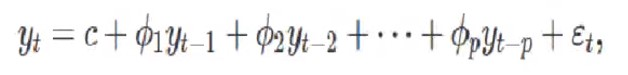

c is base value, E is white noise

For AR(1):  

*   when o1=0, yt is equivalent to white noise
*   when o1=1 and c=0, yt is equivalent to a random walk
*   when o1=1 and c!=0, yt is equivalent to random walk with drift
*   when o1<0, yt tends to oscillate around the mean




White noise has no autocorrelation beyond lag 0 ie yt is not correlated with y(t-1), y(t-2) etc


## Moving Average Models

Moving average(not same as MA models):  
MA takes average of last n terms. 
AKA Smoothening


MA models uses past forecast errors in the model

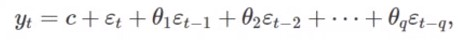

MA models tries to understand partial autocorrelation in the autoregression model

## ARIMA code

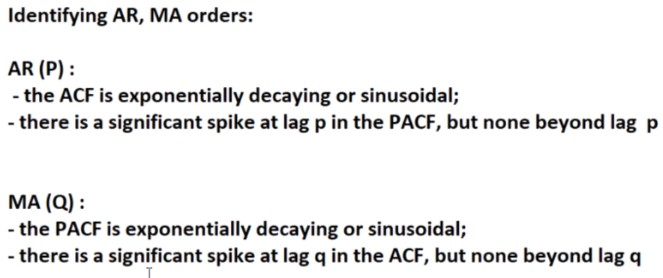

In [3]:
sales_data = pd.read_csv('Sales.csv')

In [4]:
import calendar
dates=pd.date_range(start='2003-01-01', freq='MS', periods=len(sales_data))
sales_data['Month'] = dates.month
sales_data['Month'] = sales_data['Month'].apply(lambda x: calendar.month_abbr[x])
sales_data['Year'] = dates.year



sales_data.drop(['Month-Year'], axis=1, inplace=True)
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Month', 'Year', 'Tractor-Sales']]



sales_data.set_index(dates, inplace=True)
sales_data.head(5)

,Month,Year,Tractor-Sales
2003-01-01,Jan,2003,141
2003-02-01,Feb,2003,157
2003-03-01,Mar,2003,185
2003-04-01,Apr,2003,199
2003-05-01,May,2003,203


Text(0, 0.5, 'Tractor Sales')

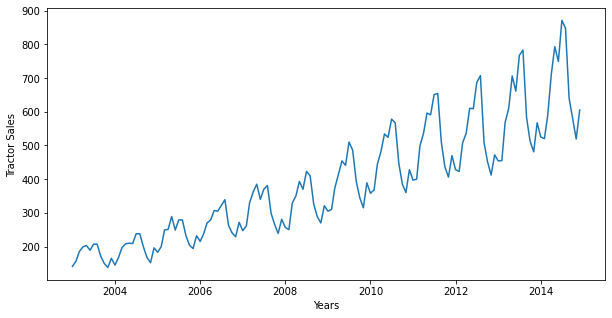

In [5]:
sales_ts = sales_data['Tractor-Sales']


plt.figure(figsize=(10, 5))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

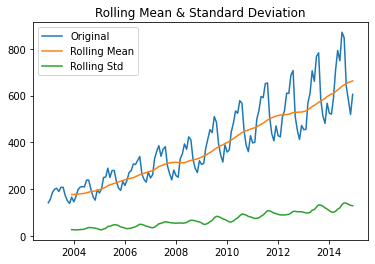

In [6]:
#Determing rolling statistics
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()



#Plot rolling statistics: (another way to check stationarity)
orig = plt.plot(sales_ts, label='Original')
mean = plt.plot(rolmean, label='Rolling Mean') #(shows trend)
std = plt.plot(rolstd, label = 'Rolling Std') #(shows seasonality)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [7]:
from statsmodels.tsa.stattools import  adfuller
s_test = adfuller(sales_data['Tractor-Sales'], autolag='AIC')

In [8]:
test_output = pd.Series(s_test[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of obs'])
test_output

Test Statistic      1.108825
p-value             0.995291
#Lags Used         14.000000
Number of obs     129.000000
dtype: float64

In [9]:
for key, value in s_test[4].items():
    print(f'Critical Value ({key}) is {value}')

Critical Value (1%) is -3.482087964046026
Critical Value (5%) is -2.8842185101614626
Critical Value (10%) is -2.578864381347275


In [13]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1) # same as ts_log_diff = ts_log - ts_log.shift(periods=1)
sales_ts_log_diff.dropna(inplace=True)

In [14]:
# ARIMA: AR, I, MA - (p, d, q) model
# I means Integrated
# p - AR order
# d - I or order differencing
# q - MA order

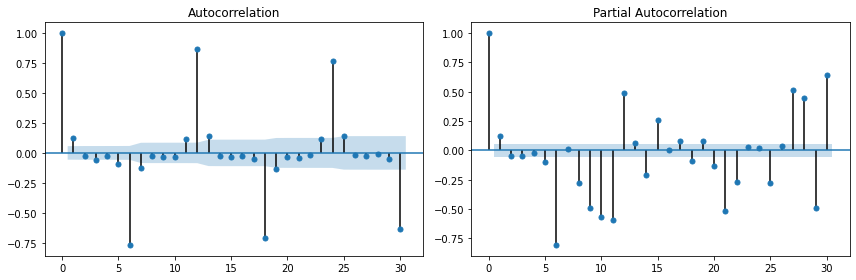

In [15]:
fig, axes = plt.subplots(1, 2, sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

Significant spike at lag 1 means AR(1) and MA(1) are both good candidates  
Spikes at 6, 12, 18, 24 means there is seasonality  
Shift from ARIMA to S-ARIMA (p, d, q, s) model  
Typically take s as 12

## SARIMA

In [ ]:
# d = (0, 1, 2) (we took differencing as 1 but then he yolo-ed)
# p, q = (0, 1, 2)
# Looking at the graph tells us AR(1) and MA(1) are good options, being on safer side we take range 
# s = 12

In [16]:
import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [20]:
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [18]:
import sys
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
            order = param,
            seasonal_order = param_seasonal,
            enforce_stationarity=True,
            enforce_invertibility=True)
            results = temp_model.fit()

            # print("SARIMAX{}x{}12 - AIC:{}".format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            print("Unexpected error:", sys.exc_info()[0])
            continue
print("Best SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))

Unexpected error: <class 'numpy.linalg.LinAlgError'>
Best SARIMAX(1, 1, 0)x(1, 0, 1, 12)12 model - AIC:-732.7299818509942


In [21]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
order=(0, 1, 1),
seasonal_order=(1, 0, 1, 12),
enforce_stationarity=True,
enforce_invertibility=True)
best_results = best_model.fit()

The Mean Squared Error of our forecasts is 0.0009


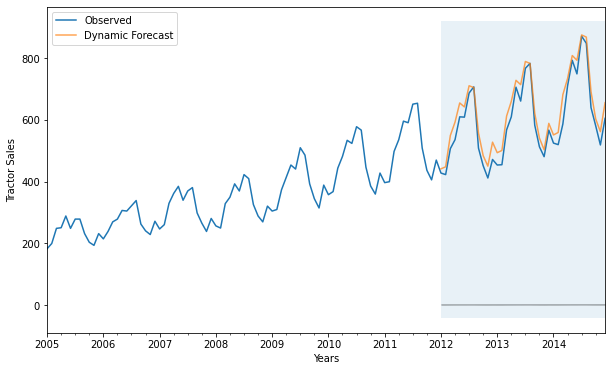

In [22]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()


# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 4)))

axis = sales_ts['2005':].plot(label='Observed', figsize=(10, 6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label='Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)
axis.fill_betweenx(axis.get_ylim(), pd.to_datetime('2012-01-01'), sales_ts.index[-1], alpha=.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()